# Review concurrent Equivital recordings

From qiosk files in a project file, extract recording per signal and a given interval of time, display values, realign data, and output csv of aligned concurrent measurements.

ALL TODO

In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import heartpy as hp

from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d

## Definitions for data extraction

In [2]:
%load_ext autoreload
%autoreload 1
%aimport qex

In [3]:
%reload_ext autoreload

# Select project for review
Check the usual spot that QIOSK deposits files for data files detailing recordings

In [3]:
# location of the files when in one of the local project files
projectName = '230214_Equivital' # this needs to match the project folder name
path = "D:\\"+projectName+"\\"#Extracted SEM Data\\" #"../Equivital/Equivital Manager Wizard/Extracted SEM Data/"
#os.listdir(path)
# sep = '/'
sep = '\\'

In [4]:
df_datafiles = qex.qiosk_recordings(path,projectName,sep)
df_datafiles

,Signal,DevName,ID,Date,Session,FileName,FileType,FileSize,RecStart,RecEnd,...,SubjectNames,SENSOR ID,SUBJECT ID,SUBJECT AGE,HR(BPM),HRC(%),BELT OFF,LEAD OFF,MOTION,BODY POSITION
0,DATA,VA304,5022110,230214,0,DATA-VA304-5022110-23021400-cut.csv,csv,80491,2023-02-14 08:55:02+00:00,2023-02-14 12:59:47+00:00,...,[VA304],5022110.0,VA304,NaN,63,98.0,0.0,0.0,Stationary,Upright
1,DATA,BR604,5022198,230214,101,DATA-BR604-5022198-23021400_0-cut.csv,csv,80215,2023-02-14 08:55:04+00:00,2023-02-14 12:59:49+00:00,...,[BR604],5022198.0,BR604,NaN,65,98.0,0.0,0.0,Stationary,Upright
2,DATA,VN205,5022060,230214,0,DATA-VN205-5022060-23021400-cut.csv,csv,80246,2023-02-14 08:55:04+00:00,2023-02-14 12:59:49+00:00,...,[VN205],5022060.0,VN205,NaN,63,99.0,0.0,0.0,Stationary,Upright
3,DATA,PC702,5022240,230214,0,DATA-PC702-5022240-23021400-cut.csv,csv,80308,2023-02-14 08:55:04+00:00,2023-02-14 12:59:49+00:00,...,[PC702],5022240.0,PC702,NaN,70,98.0,0.0,0.0,Stationary,Upright
4,DATA,VN202,5022051,230214,0,DATA-VN202-5022051-23021400-cut.csv,csv,80336,2023-02-14 08:55:04+00:00,2023-02-14 12:59:51+00:00,...,[VN202],5022051.0,VN202,NaN,84,99.0,0.0,0.0,Stationary,Upright
5,DATA,PC703,5022241,230214,0,DATA-PC703-5022241-23021400-cut.csv,csv,80996,2023-02-14 08:55:05+00:00,2023-02-14 12:59:50+00:00,...,[PC703],5022241.0,PC703,NaN,74,100.0,0.0,0.0,Stationary,Upright
6,DATA,LS401,5022138,230214,0,DATA-LS401-5022138-23021400-cut.csv,csv,80302,2023-02-14 08:55:05+00:00,2023-02-14 12:59:50+00:00,...,[LS401],5022138.0,LS401,NaN,70,99.0,0.0,0.0,Stationary,Upright
7,DATA,PC701,5022238,230214,0,DATA-PC701-5022238-23021400-cut.csv,csv,80391,2023-02-14 08:55:05+00:00,2023-02-14 12:59:50+00:00,...,[PC701],5022238.0,PC701,NaN,80,98.0,0.0,0.0,Stationary,Upright
8,DATA,WW502,5022156,230214,0,DATA-WW502-5022156-23021400-cut.csv,csv,80378,2023-02-14 08:55:06+00:00,2023-02-14 12:59:51+00:00,...,[WW502],5022156.0,WW502,NaN,70,98.0,0.0,0.0,Stationary,Upright
9,DATA,LS403,5022141,230214,0,DATA-LS403-5022141-23021400-cut.csv,csv,80401,2023-02-14 08:55:07+00:00,2023-02-14 12:59:52+00:00,...,[LS403],5022141.0,LS403,NaN,88,98.0,0.0,0.0,Stationary,Upright


In [5]:
# key categories to structure of Qiosk output DATA files
print('Number of DATA files: '+ str(len(df_datafiles)))
print(df_datafiles['ID'].unique())
print(df_datafiles['Date'].unique())
print([df_datafiles['RecStart'].min(),df_datafiles['RecStart'].max()])
print([df_datafiles['RecEnd'].min(),df_datafiles['RecEnd'].max()])

Number of DATA files: 41
[5022110 5022198 5022060 5022240 5022051 5022241 5022138 5022238 5022156
 5022141 5022142 5022050 5022117 5022104 5022193 5022100 5022057 3420415
 5023926 5022179 5022101 3420426 5022184 5022155 3420427 5022139 5022149
 5022143 5022161 5022058 5022077 5022154 5022126 3420456 5022245 5022163
 5022164 5022062 5022073 5022127 3420755]
[230214]
[Timestamp('2023-02-14 08:55:02+0000', tz='UTC'), Timestamp('2023-02-14 10:56:11+0000', tz='UTC')]
[Timestamp('2023-02-14 12:59:45+0000', tz='UTC'), Timestamp('2023-02-14 12:59:59+0000', tz='UTC')]


# Build a shared dataframe for concurrent recordings
Set the following:
- Measurement interval
- Signal
- Sample rate and timestamps in datetime and seconds (float)
- Interpolation framework


In [66]:
# signal File type and column name (multi sample)
signal_file_type = 'DATA'
sigName = 'HR(BPM)'
sample_period = 15 # seconds 
interval_name = 'Test_Session'
s_time = pd.to_datetime('2023-02-14 11:00:00+0000')
e_time = pd.to_datetime('2023-02-14 12:30:00+0000')
dur = (e_time - s_time).total_seconds()
time_s =  np.round(np.arange(0,dur,sample_period),3)

time_dt = s_time + pd.to_timedelta(time_s,unit='s')
df_sig = pd.DataFrame(index = time_dt.format(formatter=lambda x: x.strftime('%H:%M:%S')))

In [67]:
s_files = df_datafiles.copy()
# recordings started before the recording interval
s_files=s_files.loc[s_files['RecStart']< s_time,:] 
# recordings ended after the recording interval
s_files=s_files.loc[s_files['RecEnd']> e_time,:] 
print(len(s_files))

41


In [68]:
# for most signals
for i,row in s_files.iterrows():
    dataFile = row['FullLoc']
    PartName = row['DevName']

    sigFileLoc = []
    matched = qex.matched_files(dataFile,path,sep)
    for f in matched:
        if signal_file_type in f:
            sigFileLoc = f

    if sigFileLoc:
        V = pd.read_csv(sigFileLoc,skipinitialspace=True)
        V['DateTime'] = pd.to_datetime(V['DateTime'])
        sig_t = (V['DateTime'] - s_time).dt.total_seconds()
        cols = V.columns
        if sigName in cols:
            sig_v = V[sigName]
            f = interpolate.interp1d(sig_t, sig_v,fill_value='extrapolate')
            new_sig = f(time_s)
         #   if pd.Series(new_sig).diff().abs().sum()/len(new_sig)>1: # since th
            df_sig.loc[:,PartName] = new_sig

In [64]:
time_dt.format(formatter=lambda x: x.strftime('%H:%M:%S')) 


['11:00:00',
 '11:00:15',
 '11:00:30',
 '11:00:45',
 '11:01:00',
 '11:01:15',
 '11:01:30',
 '11:01:45',
 '11:02:00',
 '11:02:15',
 '11:02:30',
 '11:02:45',
 '11:03:00',
 '11:03:15',
 '11:03:30',
 '11:03:45',
 '11:04:00',
 '11:04:15',
 '11:04:30',
 '11:04:45',
 '11:05:00',
 '11:05:15',
 '11:05:30',
 '11:05:45',
 '11:06:00',
 '11:06:15',
 '11:06:30',
 '11:06:45',
 '11:07:00',
 '11:07:15',
 '11:07:30',
 '11:07:45',
 '11:08:00',
 '11:08:15',
 '11:08:30',
 '11:08:45',
 '11:09:00',
 '11:09:15',
 '11:09:30',
 '11:09:45',
 '11:10:00',
 '11:10:15',
 '11:10:30',
 '11:10:45',
 '11:11:00',
 '11:11:15',
 '11:11:30',
 '11:11:45',
 '11:12:00',
 '11:12:15',
 '11:12:30',
 '11:12:45',
 '11:13:00',
 '11:13:15',
 '11:13:30',
 '11:13:45',
 '11:14:00',
 '11:14:15',
 '11:14:30',
 '11:14:45',
 '11:15:00',
 '11:15:15',
 '11:15:30',
 '11:15:45',
 '11:16:00',
 '11:16:15',
 '11:16:30',
 '11:16:45',
 '11:17:00',
 '11:17:15',
 '11:17:30',
 '11:17:45',
 '11:18:00',
 '11:18:15',
 '11:18:30',
 '11:18:45',
 '11:19:00',

In [75]:
df_sig.iloc[100,:]

VA304     68.600000
BR604     68.466667
VN205     64.933333
PC702     73.466667
VN202     81.266667
PC703     77.000000
LS401     71.000000
PC701     93.000000
WW502     67.800000
LS403     91.000000
LS404     73.600000
VN201     77.933333
VA305     69.600000
VA303     82.000000
BR603     85.400000
VA301     91.333333
VN203     69.733333
VN101     63.800000
LS406     66.000000
BR601     79.466667
VA302     85.400000
VN102     76.066667
BR602     73.000000
WW501    100.333333
VN103     94.000000
LS402    107.000000
LS407     82.000000
LS405     82.000000
WW503    100.666667
VN204     74.600000
VN209     75.000000
LS410     91.266667
VA306     82.400000
VN104     98.666667
PC705     30.200000
WW504     80.200000
WW505     97.800000
VN206     64.266667
VN207     61.000000
VA307     80.866667
VN105     64.800000
Name: 11:25:00, dtype: float64

In [ ]:
# for acceleration
for i,row in s_files.iterrows():
    dataFile = row['FullLoc']
    PartName = row['DevName']

    sigFileLoc = []
    matched = qex.matched_files(dataFile,path,sep)
    for f in matched:
        if signal_file_type in f:
            sigFileLoc = f

    if sigFileLoc:
        V = pd.read_csv(sigFileLoc,skipinitialspace=True)
        V['DateTime'] = pd.to_datetime(V['DateTime'])
        sig_t = (V['DateTime'] - s_time).dt.total_seconds()
        cols = V.columns
        df = V.loc[:,[ 'Vert Accelerometer','Lat Accelerometer','Long Accelerometer']]
        sig_v = np.sqrt(np.square(df.diff()).sum(axis=1))
        f = interpolate.interp1d(sig_t,sig_v,fill_value='extrapolate')
        new_sig = f(time_s)
        if pd.Series(new_sig).diff().abs().sum()/len(new_sig)>1: # since th
            df_sig.loc[:,PartName] = new_sig

<AxesSubplot:>

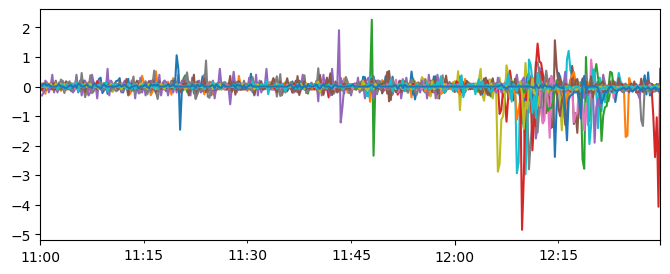

In [35]:
df_sig.diff().plot(legend = False,figsize = [8,3])

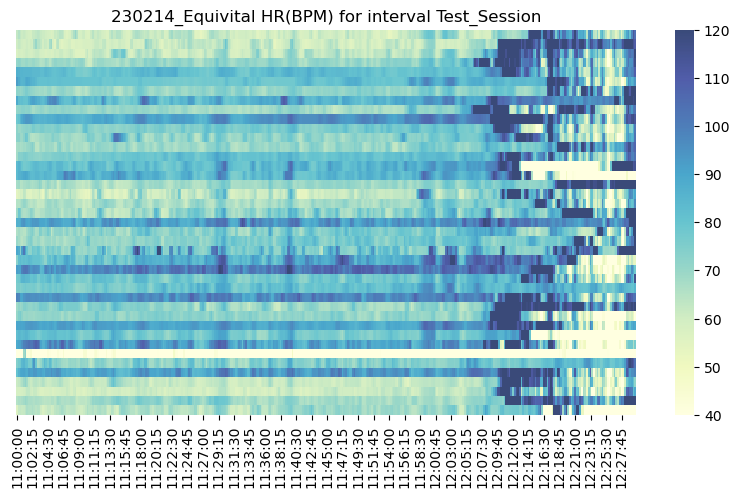

In [73]:
fig, (ax1) = plt.subplots(1, 1,figsize = [10,5])
chart = sns.heatmap(data=df_sig.transpose(), ax=ax1,vmin=40, vmax=120, cbar=True, cmap="YlGnBu",alpha=0.8)
ax1.set_yticks([])
plt.title(projectName + ' ' + sigName + ' for interval ' + interval_name)
plt.savefig('./plots/'+projectName+'_'+ interval_name+ '_set_'+sigName+'.png',dpi = 300)
plt.show()

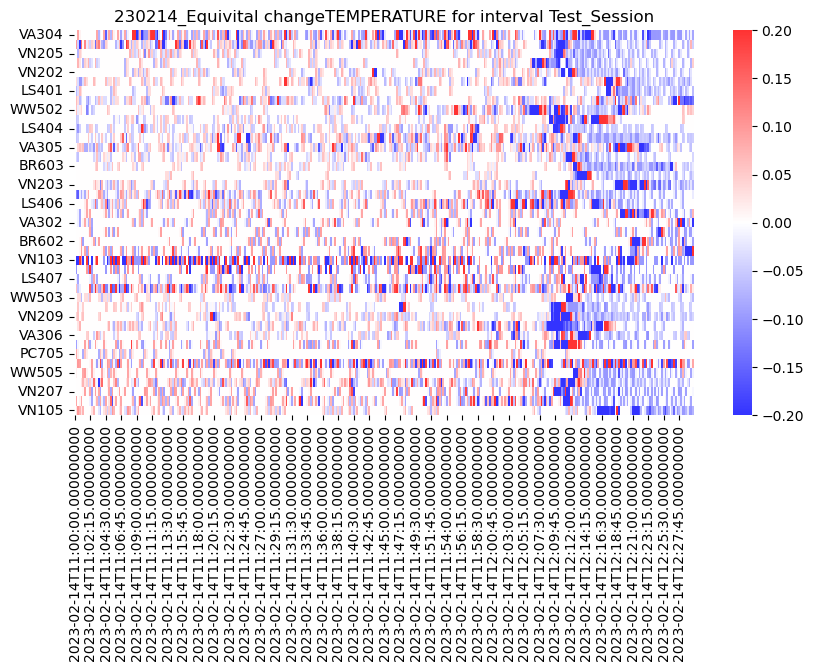

In [40]:
fig, (ax1) = plt.subplots(1, 1,figsize = [10,5])
chart = sns.heatmap(data=df_sig.diff().transpose(), ax=ax1,vmin=-0.2, vmax=0.2, cbar=True, cmap="bwr", alpha=0.8)
plt.title(projectName + ' change' + sigName + ' for interval ' + interval_name)
plt.savefig('./plots/'+projectName+'_'+ interval_name+ '_set_d'+sigName+'.png',dpi = 300)
plt.show()

NameError: name 'df_sig' is not defined

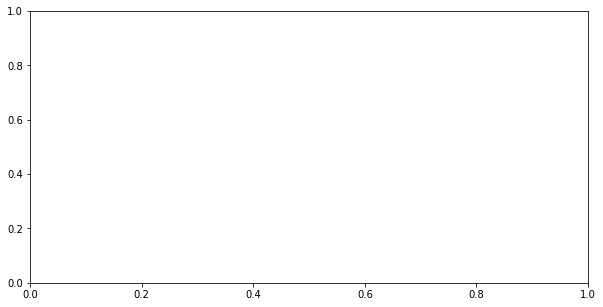

In [10]:
# for Breathing
fig, (ax1) = plt.subplots(1, 1,figsize = [10,5])
chart = sns.heatmap(data=df_sig.diff().transpose(),vmin=-20, vmax=20, ax=ax1,cbar=True,alpha=0.8)
# new_xticks = len(df_sig)*(key_times['CTime'])/(All_ACC.index[-1])
# ax1.set_xticks(new_xticks)
# ax1.set_xticklabels(key_times['event'])
# ax1.tick_params(axis='x',grid_color='k',labelrotation=30)
plt.title(projectName + ' ' + sigName + ' for interval ' + interval_name)
# plt.ylabel(sigName)
plt.savefig('./plots/'+projectName+'_'+ interval_name+ '_set_'+sigName+'.png',dpi = 300)
plt.show()

In [142]:
# save output 
df_sig.to_csv('./out_data/'+projectName+'_'+ interval_name+ '_set_'+sigName+'.csv')